### Processing data to run PCA and then NN

In [1]:
cd ../Python/

/Users/cesarosorio/Kaggle/PainterbyNumbers/fifth_floor_art_critics/Python


In [2]:
import readPBNData.description as rd
import readPBNData.images as ri

In [3]:
csvs, fileLike = rd.openZip('../Data/train_info.csv.zip')
lines, head = rd.readCSV(fileLike[0])

TypeError: 'str' does not support the buffer interface

In [5]:
print(head)
lines[:2]

['filename', 'artist', 'title', 'style', 'genre', 'date']


[['102257.jpg',
  '5b39c876740bfc1cfaf544721c43cac3',
  'Uriel',
  'Color Field Painting',
  'abstract',
  '1955.0'],
 ['75232.jpg',
  '5b39c876740bfc1cfaf544721c43cac3',
  'Vir Heroicus Sublimis',
  'Color Field Painting',
  'abstract',
  '1950.0']]

In [7]:
cols = rd.columns(lines,head)
cols.keys()

['style', 'title', 'artist', 'filename', 'date', 'genre']

In [75]:
colsdf=pd.DataFrame(cols)
colsdf

,artist,date,filename,genre,style,title
0,5b39c876740bfc1cfaf544721c43cac3,1955.0,102257.jpg,abstract,Color Field Painting,Uriel
1,5b39c876740bfc1cfaf544721c43cac3,1950.0,75232.jpg,abstract,Color Field Painting,Vir Heroicus Sublimis
2,96e5bc98488ed589b9bf17ad9fd09371,,29855.jpg,mythological painting,Yamato-e,Night March of a Hundred Demons (left half)
3,5b39c876740bfc1cfaf544721c43cac3,,62252.jpg,abstract,Color Field Painting,"Who’s Afraid of Red, Yellow and Blue II"
4,5b39c876740bfc1cfaf544721c43cac3,1963.0,63861.jpg,abstract,Color Field Painting,Black Fire I
5,782192dc825c7c1149825adcb7caacbc,1844,53180.jpg,bird-and-flower painting,Ukiyo-e,Camellia and Bush Warbler
6,afdfc43410410892bc9d1c4d3c3d6220,1937.0,70944.jpg,landscape,Surrealism,Forbidden Land
7,9f0984ce62483f294fc666d74e0974f6,,59792.jpg,religious painting,Northern Renaissance,Descent from the cross
8,3a40b18a78ceb822961393c50bdb522b,,48138.jpg,landscape,Ukiyo-e,Snowy landscape with a woman brandishing a bro...
9,d09f796f2b0aa11dffc88badd9806119,1873,99442.jpg,marina,Romanticism,Storm at sea


In [9]:
cols['title'][:10]

['Uriel',
 'Vir Heroicus Sublimis',
 'Night March of a Hundred Demons (left half)',
 'Who\xe2\x80\x99s Afraid of Red,  Yellow and Blue II',
 'Black Fire I ',
 'Camellia and Bush Warbler',
 'Forbidden Land ',
 'Descent from the cross',
 'Snowy landscape with a woman brandishing a broom and a man holding an umbrella',
 'Storm at sea']

In [121]:
img = ri.openZipImage('../Data/train_1.zip',cols['filename'][0],prefix='train_1')

In [122]:
img.show()

In [83]:
new2= img.resize(size=(100,100))

In [90]:
print(new2.getdata())

In [108]:
new= img.resize(size=(100,100))

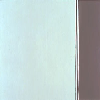

In [109]:
new

In [44]:
print(new.format, new.size, new.mode)

None (100, 100) RGB


In [1]:
#r, g, b = new.split()
#r

In [10]:
import zipfile
import os
zf = zipfile.ZipFile('../Data/train_1.zip','r')
filenames = zf.namelist()[1:]
filenames[:10]
#print([os.path.basename(h) for h in filenames])

#os.path.basename(filenames[2])

['train_1/1.jpg',
 'train_1/10.jpg',
 'train_1/100.jpg',
 'train_1/1000.jpg',
 'train_1/10000.jpg',
 'train_1/100001.jpg',
 'train_1/100002.jpg',
 'train_1/100003.jpg',
 'train_1/100006.jpg',
 'train_1/100007.jpg']

In [11]:
len(filenames)

11025

In [196]:
import readPBNData.description as rd
import readPBNData.images as ri
from PIL import Image, ImageMath
import numpy as np

mylist=[]
invalid = pd.DataFrame()
for h in range(2000):
    #del img, new, cleanlist
    img = ri.openZipImage('../Data/train_1.zip',filenames[h])
    try:
        new= img.resize(size=(100,100))
    except IOError as e:
        invalid = invalid.append([[filenames[h], e]],ignore_index=True)
    cleanlist=np.array(new).flatten()
    mylist.append([cleanlist,os.path.basename(filenames[h])])
mylist=np.array(mylist)


In [197]:
invalid

,0,1
0,train_1/101947.jpg,image file is truncated (82 bytes not processed)


In [194]:
mylist[1200:1300]

array([[array([208, 195, 189, ..., 127,  90,  46], dtype=uint8),
        '101444.jpg'],
       [array([182, 187, 219, ..., 213, 176, 131], dtype=uint8),
        '101445.jpg'],
       [array([225, 182, 210, ...,  15,  12,  41], dtype=uint8),
        '101447.jpg'],
       [array([122,  51,  65, ...,  31,   4,  13], dtype=uint8),
        '101448.jpg'],
       [array([140, 155, 134, ...,  35,  39,  40], dtype=uint8),
        '101449.jpg'],
       [array([84, 84, 96, ..., 20, 22, 47], dtype=uint8), '101451.jpg'],
       [array([160, 176, 166, ...,  65,  49,  33], dtype=uint8),
        '101452.jpg'],
       [array([ 64,  64,  64, ..., 223, 223, 223], dtype=uint8),
        '101453.jpg'],
       [array([252, 254, 253, ..., 243, 228, 199], dtype=uint8),
        '101454.jpg'],
       [array([186, 171, 132, ..., 162, 148, 122], dtype=uint8),
        '101455.jpg'],
       [array([171, 188, 204, ..., 160, 141,  99], dtype=uint8),
        '101457.jpg'],
       [array([ 87, 120, 155, ...,  36,  56,  

In [198]:
#mylist2[:,0][0]
df = pd.DataFrame({'pixels':mylist[:,0],'filename':mylist[:,1]})
#mylist[:,1]

In [199]:
df

,filename,pixels
0,1.jpg,"[255, 255, 255, 252, 252, 252, 255, 255, 255, ..."
1,10.jpg,"[113, 88, 92, 79, 49, 49, 93, 52, 46, 104, 66,..."
2,100.jpg,"[155, 139, 114, 142, 144, 131, 82, 87, 83, 77,..."
3,1000.jpg,"[140, 132, 130, 118, 130, 152, 108, 122, 161, ..."
4,10000.jpg,"[60, 69, 66, 52, 59, 69, 49, 57, 68, 48, 57, 6..."
5,100001.jpg,"[155, 125, 65, 143, 113, 53, 154, 123, 66, 150..."
6,100002.jpg,"[0, 116, 23, 0, 108, 20, 0, 103, 16, 0, 102, 1..."
7,100003.jpg,"[252, 253, 248, 250, 251, 246, 253, 252, 248, ..."
8,100006.jpg,"[121, 118, 135, 136, 137, 93, 136, 132, 85, 14..."
9,100007.jpg,"[144, 178, 205, 143, 177, 204, 134, 171, 197, ..."


In [200]:
result = pd.merge(df, colsdf, on='filename')
#result = pd.concat([df, colsdf], axis=1, join_axes=[df.filename])
result

,filename,pixels,artist,date,genre,style,title
0,1.jpg,"[255, 255, 255, 252, 252, 252, 255, 255, 255, ...",1468ab18764365ded902fc726aec2c89,1918,flower painting,Expressionism,Sunflowers
1,10.jpg,"[113, 88, 92, 79, 49, 49, 93, 52, 46, 104, 66,...",8f59e3f70611b198f0536f60187cb64b,c.1645,religious painting,Baroque,The Supper at Emmaus
2,100.jpg,"[155, 139, 114, 142, 144, 131, 82, 87, 83, 77,...",4c0ed92a11812f892c9c02be3a9a8cef,1932.0,landscape,Post-Impressionism,Red House
3,1000.jpg,"[140, 132, 130, 118, 130, 152, 108, 122, 161, ...",dcb1d130c7640aefc60890d0e90d472d,1903,landscape,Realism,Oka. Evening.
4,10000.jpg,"[60, 69, 66, 52, 59, 69, 49, 57, 68, 48, 57, 6...",485d901dc4df30b128bf01cb6e229767,1947.0,portrait,Sōsaku hanga,Profile of Brown Haired Woman
5,100001.jpg,"[155, 125, 65, 143, 113, 53, 154, 123, 66, 150...",6248ab5476368372fd92a0b3686d53d2,1911,nude painting (nu),Impressionism,Male Figure Standing
6,100002.jpg,"[0, 116, 23, 0, 108, 20, 0, 103, 16, 0, 102, 1...",d47d74303755d4481b407700fa063abb,1952,abstract,Pop Art,Rapt at Rappaport's
7,100003.jpg,"[252, 253, 248, 250, 251, 246, 253, 252, 248, ...",80687062449ff7454e2c8926be56f643,c.1923,illustration,Naïve Art (Primitivism),Gogol and Chagall
8,100006.jpg,"[121, 118, 135, 136, 137, 93, 136, 132, 85, 14...",dd4989789d310581024ae2b9203d5439,1876,portrait,Impressionism,Victor Chocquet
9,100007.jpg,"[144, 178, 205, 143, 177, 204, 134, 171, 197, ...",c60d424faa55b528a37b3199959e1f5c,1662.0,landscape,Baroque,Road through Corn Fields near the Zuider Zee


(2000, 2)

In [203]:
grouped = result.groupby('artist')
np.sort(grouped.size())[-200:]
#np.sort(grouped.size())[-50:]
#grouped.size().sort_values(axis=0, ascending=True)
#result.groupby('artist', sort=True).sum()

array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
        9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 12, 12, 12, 13, 14, 14, 14, 15, 15])

In [210]:
#grouped.groups
final=grouped.filter(lambda x: len(x) > 9)
final
#result.artist[np.sort(grouped.size())[-100:]]

,filename,pixels,artist,date,genre,style,title
8,100006.jpg,"[121, 118, 135, 136, 137, 93, 136, 132, 85, 14...",dd4989789d310581024ae2b9203d5439,1876,portrait,Impressionism,Victor Chocquet
11,10001.jpg,"[171, 164, 180, 188, 179, 164, 191, 177, 174, ...",b36edf57ed623e40e433565053f5f6ca,1955.0,portrait,Naïve Art (Primitivism),Mother and child
19,10002.jpg,"[255, 255, 255, 52, 52, 52, 179, 179, 179, 232...",62b4406512c45730d2c7c40f5e3d0d12,1934,illustration,Surrealism,"Illustration to ""A Week of Kindness"""
28,100031.jpg,"[109, 105, 67, 191, 199, 162, 194, 213, 168, 1...",10bc951c2eb4a2f05fa773bdaace4e3b,1890,landscape,Post-Impressionism,Cypresses and Two Women
38,100044.jpg,"[123, 108, 75, 176, 160, 145, 128, 120, 107, 1...",234c8d1df0b49b512791078cf00cf352,1873,landscape,Impressionism,"Factory in the Flood, Bougival"
39,100045.jpg,"[216, 186, 134, 223, 193, 141, 233, 206, 137, ...",bd14ef3c1a25cf0c5368ccd92a3c5f04,1916,landscape,Symbolism,Landscape. Village Neskuchnoye
43,100051.jpg,"[195, 196, 201, 201, 202, 207, 189, 189, 201, ...",5fc2ffdd3d24ab503edd9a271dc379bd,1853,landscape,Realism,"Morning, Fog Effect"
45,100053.jpg,"[145, 131, 96, 178, 171, 145, 197, 196, 178, 2...",b36edf57ed623e40e433565053f5f6ca,,design,Naïve Art (Primitivism),Opera
47,100057.jpg,"[75, 49, 50, 82, 63, 65, 68, 58, 57, 99, 60, 6...",40f86d376acde0d9862ce7493745bdae,c.1963,landscape,Symbolism,Desoxyribonucleic Acid Arabs
49,100060.jpg,"[228, 228, 216, 218, 218, 206, 225, 228, 209, ...",0eeac4ecff259dc515be795e1a76019a,1906.0,genre painting,Art Nouveau (Modern),Province (Kostroma)


In [352]:
# Create classes based on artist (only 24 artist in this sample, the most frequent ones)
uniq = sorted(list(set(final['artist'])))
artnum = [uniq.index(x) for x in final['artist']]
# Put the data in the right format to run the NN
frame2=[pd.DataFrame(final['pixels'].tolist()),pd.DataFrame(artnum)]
datafinal=pd.concat(frame2, axis=1).dropna(axis=0)
datafinal.columns = [list(range(30001))]

y_class = datafinal[30000]
X_train = datafinal.ix[:,0:29999]
y_train = y_class
#X_test = dtm[n_break:n_final]
#y_test = y_class[n_break:n_final]
print(X_train.shape,y_train.shape,type(y_train))

((270, 30000), (270,), <class 'pandas.core.series.Series'>)


In [333]:
#final['pixels'].tolist()
#pd.DataFrame(data=final['pixels'].tolist())
#final['artist']
#X_train
#pd.isnull(X_train[29990])
#X_train.dropna(axis=0).shape
#datafinal=pd.DataFrame({final['pixels'].tolist(),artnum})
#frame2=[pd.DataFrame(final['pixels'].tolist()),pd.DataFrame(artnum)]
#datafinal=pd.concat(frame2, axis=1).dropna(axis=0)
#datafinal.columns = [list(range(30001))]

In [355]:
#pd.DataFrame(final['pixels'].tolist())
#pd.DataFrame(artnum).transpose()
#datafinal[30000]
#range(10)
#X_train

### Principal Component Analysis to MOvie data

explained variance ratio (first n components): 1.0
(270, 270)


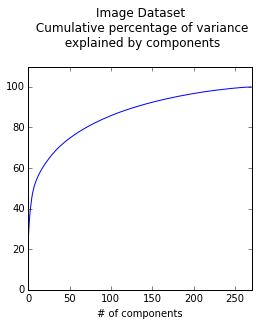

In [359]:
# Principal Component Analysis to MOvie data

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.preprocessing import scale
%matplotlib inline
# Note that I use scale and then PCA with Whitening, because whitening eliminates
# correlation among features but scaling only affects the features independently
components= 270
pca = PCA( n_components = components,whiten=True )
#pca = RandomizedPCA(n_components = 200, random_state=0 )
X_pca = pca.fit_transform(scale(X_train))
#X_pca_test = pca.transform(scale(X_test))

# Percentage of variance explained for each components
print('explained variance ratio (first n components): %s'
      % str(sum(pca.explained_variance_ratio_)))
print(X_pca.shape)

#eigenvalues = pca.explained_variance_
plt.figure(figsize=(4, 4))
eigencumul=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(range(components),eigencumul)

plt.ylim(0, 110)
plt.xlim(0, components)
#plt.ylabel('Error')
plt.xlabel('# of components')
plt.title('Image Dataset \n Cumulative percentage of variance \n explained by components \n', fontsize=12, ha='center')

### Applying a NN using Theano

In [368]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib
import theano
import theano.tensor as T
#import pydot_ng
#import pydot
from IPython.display import Image
from IPython.display import SVG
from sklearn.preprocessing import scale
import timeit
from time import time

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)



# Note to TAs: you have to un comment the paragrah below to calculate results for
# the different variables

##Movie data

## Original data
train_y = y_train.astype(np.int32)
#test_y = y_test.astype(np.int32)
train_X = scale(X_train).astype(np.float32)
#test_X = scale(X_test).astype(np.float32)



# Size definitions
num_examples = len(train_X) # training set size
nn_input_dim = train_X.shape[1] # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality (2 for Movie data and 4 for Wine data)
nn_hdim = 3 # hiden layer dimensionality

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength 

# Our data vectors
X = T.matrix('X') # matrix of doubles
y = T.lvector('y') # vector of int64

# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim), name='b2')

# Forward propagation
# Note: We are just defining the expressions, nothing is evaluated here!
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2) # output probabilties

# The regularization term (optional)
loss_reg = 1./num_examples * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 
# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

# Returns a class prediction
prediction = T.argmax(y_hat, axis=1)

# Theano functions that can be called from our Python code
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

# Easy: Let Theano calculate the derivatives for us!
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

ImportError: No module named pydot

In [367]:
# This function learns parameters for the neural network and returns the model.
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 100 iterations
train_errorsNN = []
test_errorsNN = []
num_passes= 2000
def build_model(num_passes=num_passes, print_loss=False):
    
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 100 == 0:
            #print("Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y)))
            train_errorsNN.append(1. - np.mean(predict(train_X)==train_y))
            #test_errorsNN.append(1. - np.mean(predict(test_X)==test_y))
  
# Build a model with a n-dimensional hidden layer

t0 = time()
build_model(print_loss=True)
print("done in %0.3fs." % (time() - t0))

# Plot the decision boundary
#plot_decision_boundary(lambda x: predict(x))
#plt.title("Decision Boundary for hidden layer size 3")

ValueError: y_i >= dx dimensions[1] or y_i < 0.
Apply node that caused the error: CrossentropySoftmax1HotWithBiasDx(Elemwise{Composite{inv(Cast{float64}(i0))}}.0, SoftmaxWithBias.0, y)
Toposort index: 11
Inputs types: [TensorType(float64, (True,)), TensorType(float64, matrix), TensorType(int64, vector)]
Inputs shapes: [(1,), (270, 2), (270,)]
Inputs strides: [(8,), (16, 8), (8,)]
Inputs values: [array([ 0.0037037]), 'not shown', 'not shown']
Outputs clients: [[Sum{axis=[0], acc_dtype=float64}(CrossentropySoftmax1HotWithBiasDx.0), Dot22(CrossentropySoftmax1HotWithBiasDx.0, W2.T), Gemm{inplace}(W2, TensorConstant{-0.01}, InplaceDimShuffle{1,0}.0, CrossentropySoftmax1HotWithBiasDx.0, TensorConstant{0.99999962963})]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/cesarosorio/anaconda/envs/py27/lib/python2.7/site-packages/theano/gradient.py", line 561, in grad
    grad_dict, wrt, cost_name)
  File "/Users/cesarosorio/anaconda/envs/py27/lib/python2.7/site-packages/theano/gradient.py", line 1324, in _populate_grad_dict
    rval = [access_grad_cache(elem) for elem in wrt]
  File "/Users/cesarosorio/anaconda/envs/py27/lib/python2.7/site-packages/theano/gradient.py", line 1279, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/Users/cesarosorio/anaconda/envs/py27/lib/python2.7/site-packages/theano/gradient.py", line 973, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/Users/cesarosorio/anaconda/envs/py27/lib/python2.7/site-packages/theano/gradient.py", line 1279, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/Users/cesarosorio/anaconda/envs/py27/lib/python2.7/site-packages/theano/gradient.py", line 973, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "/Users/cesarosorio/anaconda/envs/py27/lib/python2.7/site-packages/theano/gradient.py", line 1279, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/Users/cesarosorio/anaconda/envs/py27/lib/python2.7/site-packages/theano/gradient.py", line 1113, in access_term_cache
    input_grads = node.op.grad(inputs, new_output_grads)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

### Just trying stuff

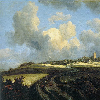

In [313]:
# Convert image to array , and then from array to image
im = np.array(new)
#im.flatten().reshape(100,100,3)
im3 = Image.fromarray(im.flatten().reshape(100,100,3))
im3

In [322]:
im = array(new)
im.shape

(100, 100, 3)

In [255]:
immatrix
imlist=[new, new]
len(imlist)

2

In [329]:
imlist=[array(new).reshape(-1, 3), array(new).reshape(-1, 3)]
len(imlist)

2

In [331]:
#im.reshape(-1, 3).shape

imlist=[array(new).reshape(-1, 3), array(new).reshape(-1, 3)]
im = imlist[0] # open one image to get size
m,n = im.shape[0:2] # get the size of the images
imnbr = len(imlist) # get the number of images

# create matrix to store all flattened images
#immatrix = array([array(Image.open(im)).flatten()
              #for j in imlist],'f')

# create matrix to store all flattened images
immatrix = array([imlist[i].flatten()
              for i in range(len(imlist))],'f')



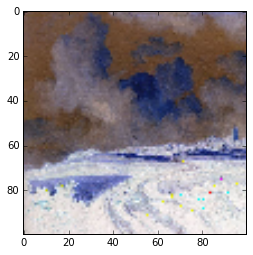

In [277]:
imshow(immean.reshape(m,n,r))

In [308]:
immatrix.mean(axis=0).shape

(30000,)

In [280]:
pca2(immatrix)[2]

/Users/cesarosorio/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in divide


(30000,)

In [284]:
V[1].reshape(m,n,r).shape

(100, 100, 3)

In [332]:
immatrix.shape

(2, 30000)

In [343]:
V.shape

(2, 30000)

In [349]:
mean_X = X.mean(axis=0)
mean_X

array([  92.71868896,   97.71647644,  107.8917923 , ...,  120.62600708,
        113.31496429,  105.59957123], dtype=float32)

In [340]:
immatrix

array([[ 144.,  178.,  205., ...,   19.,   20.,   22.],
       [ 144.,  178.,  205., ...,   19.,   20.,   22.]], dtype=float32)

In [351]:
S

array([ 34740.4765625,      0.       ], dtype=float32)

In [360]:
X=immatrix
M = dot(X,X.T)
linalg.eigh(M)

(array([  0.00000000e+00,   1.20690061e+09], dtype=float32),
 array([[-0.70710677,  0.70710677],
        [ 0.70710677,  0.70710677]], dtype=float32))

In [361]:
X.shape

(2, 30000)